# Data Cleaning

### 0. Import necessary libraries

In [1]:
import gc
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm import tqdm_notebook


DATA_FOLDER = '../data/'
d_parser = lambda x: pd.datetime.strptime(x,'%d.%m.%Y')

warnings.filterwarnings("ignore")
import utils

### 1. Read the data

In [2]:
%%time

df_sales           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'), parse_dates =["date"],date_parser=d_parser)
df_items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
df_item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
df_shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

Wall time: 1min 46s


### 2. Check for outliers
Since, the outliers, can be found in item_cnt_day, that is the total quantity sold, and item_price, so will check both

In [3]:
df_sales.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


Outliers for item_cnt_day :  [1000.  624.  637.  669. 2169.]
Wall time: 288 ms


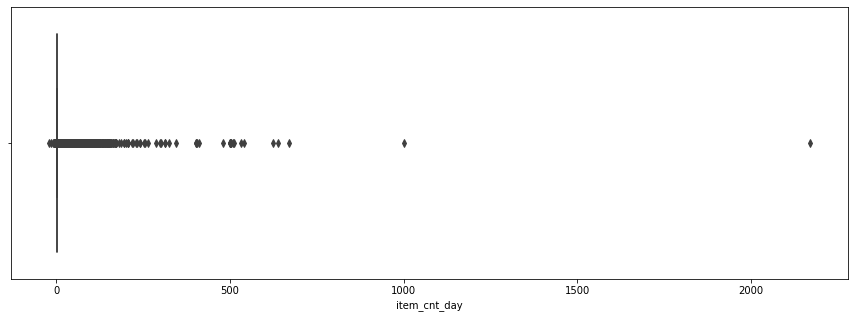

In [4]:
%%time
# for item quantity
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_cnt_day'])
print('Outliers for item_cnt_day : ', df_sales[df_sales['item_cnt_day']>600]['item_cnt_day'].unique())

In [5]:
%%time
# deleting the quantities which are greater than 600
df_sales = df_sales[df_sales['item_cnt_day']<=600]

Wall time: 275 ms


Outliers for item_price :  [ 59200. 307980.]
Wall time: 335 ms


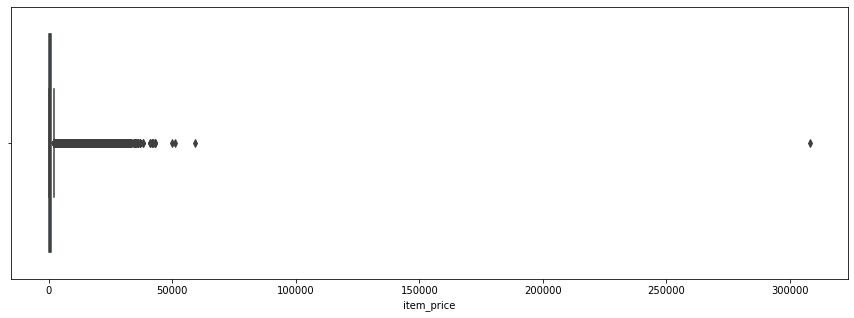

In [6]:
%%time
# checking for price
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_price'])
print('Outliers for item_price : ', df_sales[df_sales['item_price']>55000]['item_price'].unique())

In [7]:
%%time
# values more than 55k could be outliers, so deleting all above 55k
df_sales = df_sales[df_sales['item_price']<= 55000]

Wall time: 290 ms


### 3. Re-Checking after deletion of Outliers

Wall time: 262 ms


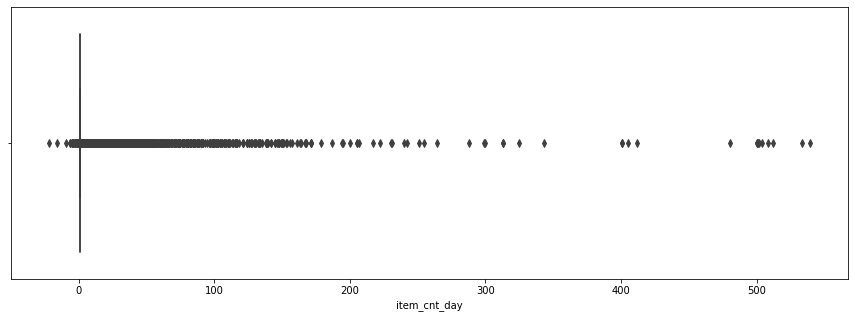

In [8]:
%%time
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_cnt_day'])

Wall time: 281 ms


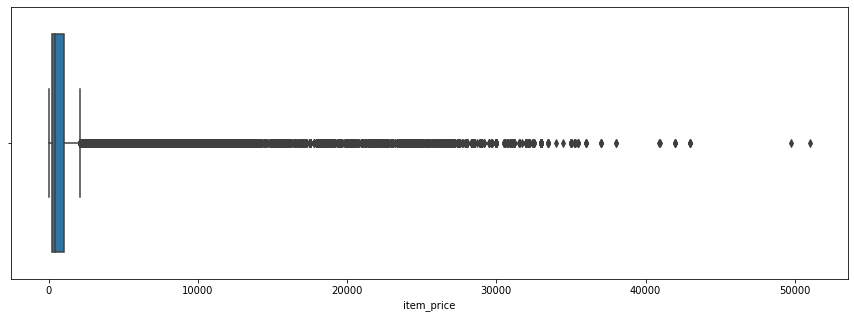

In [9]:
%%time
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_price'])

In [10]:
#instantiate the object (all important functions are gathered in this class)
sales_util = utils.SalesUtils('')

In [11]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


### 4. Combining all Data-Sets to make one master for our Analysis

In [12]:
%%time

# Adding the date time attributes (like week day, month number, etc.)
df_sales = sales_util.add_date_attributes(df_sales)

############    ITEMS      ##############
# parsing the item categories (i.e. adding the parent category on top of the item_category)
df_item_categories = sales_util.parse_item_categories(df_item_categories)
# merging the items with item categories
df_items = df_items.merge(df_item_categories, how='inner', on=['item_category_id'])

############    SHOPS      ##############
# Adding the city_id and city_name to the shops
sales_util.parse_shop_names(df_shops)

# merging the sales with the items
df_sales = df_sales.merge(df_items[['item_id','item_category_id','parent_cat_id','parent_cat']].drop_duplicates(), how='inner')

# merging the sales with the shops 
df_sales = df_sales.merge(df_shops[['shop_id','city_id','city_name']].drop_duplicates(), how='inner')

Wall time: 7.76 s


### 5. Adding the public holidays to the dataset
* I have gathered all the public holidays from google for the company's country of origin 

In [13]:
%%time 

# adding the column
df_sales['is_holiday'] = 0

# adding 1 to the specified dates
holidays_list = ['1:1','1:25','2:15','2:27','3:25','4:21','4:26','4:27','6:6','6:8','8:6','8:12','8:27','9:13','9:29','10:1',
                '10:4','10:23','10:24','10:25','10:29','10:30','10:31','11:10','11:19','11:27','12:9','12:17']

for holiday in tqdm_notebook(holidays_list):
    
    # getting the holiday month and day
    m = holiday.split(':')[0] 
    d = holiday.split(':')[1]
    
    m = int(m)
    d = int(d)
    
    # getting the indexes for the holidays    
    dt = df_sales[(df_sales['day']==d) & (df_sales['month']==m)].index
    
    for idx in dt:
        # updating the sales data        
        df_sales.at[idx,'is_holiday'] = 1



Wall time: 9.28 s


In [14]:
print('total holidays in dataset are ', len(df_sales[df_sales['is_holiday']==1]))

total holidays in dataset are  208076


### 6. Down-casting

In [15]:
%%time
df_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935842 entries, 0 to 2935841
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   day               int64         
 7   month             int64         
 8   weekday           object        
 9   weekdayno         int64         
 10  year              int64         
 11  item_category_id  int64         
 12  parent_cat_id     int32         
 13  parent_cat        object        
 14  city_id           int64         
 15  city_name         object        
 16  is_holiday        int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(10), object(3)
memory usage: 899.9 MB
Wall time: 38.9 s


In [16]:
%%time
# down casting
df_sales['date_block_num'] = df_sales['date_block_num'].astype('int8')
df_sales['shop_id'] = df_sales['shop_id'].astype('int8')
df_sales['item_id'] = df_sales['item_id'].astype('int16')
df_sales['item_price'] = df_sales['item_price'].astype('float16')
df_sales['item_cnt_day'] = df_sales['item_cnt_day'].astype('int16')
df_sales['day'] = df_sales['day'].astype('int8')
df_sales['month'] = df_sales['month'].astype('int8')
df_sales['weekdayno'] = df_sales['weekdayno'].astype('int8')
df_sales['year'] = df_sales['year'].astype('int16')
df_sales['item_category_id'] = df_sales['item_category_id'].astype('int8')
df_sales['parent_cat_id'] = df_sales['parent_cat_id'].astype('int8')
df_sales['parent_cat_id'] = df_sales['parent_cat_id'].astype('int8')
df_sales['is_holiday'] = df_sales['is_holiday'].astype('int8')
df_sales['city_id'] = df_sales['city_id'].astype('int8')

# as we have number representations for both of the below, they will be deleted after eda
df_sales['weekday'] = df_sales['weekday'].astype('category')
df_sales['parent_cat'] = df_sales['parent_cat'].astype('category')

Wall time: 2.54 s


In [17]:
%%time
df_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935842 entries, 0 to 2935841
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int8          
 2   shop_id           int8          
 3   item_id           int16         
 4   item_price        float16       
 5   item_cnt_day      int16         
 6   day               int8          
 7   month             int8          
 8   weekday           category      
 9   weekdayno         int8          
 10  year              int16         
 11  item_category_id  int8          
 12  parent_cat_id     int8          
 13  parent_cat        category      
 14  city_id           int8          
 15  city_name         object        
 16  is_holiday        int8          
dtypes: category(2), datetime64[ns](1), float16(1), int16(3), int8(9), object(1)
memory usage: 315.9 MB
Wall time: 13 s


##### we saved huge memory !!

In [18]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,weekday,weekdayno,year,item_category_id,parent_cat_id,parent_cat,city_id,city_name,is_holiday
0,2013-01-02,0,59,22154,999.0,1,2,1,Wednesday,2,2013,37,6,cinema,31,Yaroslavl,0
1,2013-05-16,4,59,2573,249.0,1,16,5,Thursday,3,2013,55,13,music,31,Yaroslavl,0
2,2013-01-26,0,59,2574,399.0,1,26,1,Saturday,5,2013,55,13,music,31,Yaroslavl,0
3,2013-01-09,0,59,2574,399.0,1,9,1,Wednesday,2,2013,55,13,music,31,Yaroslavl,0
4,2013-02-24,1,59,2574,399.0,1,24,2,Sunday,6,2013,55,13,music,31,Yaroslavl,0


### 7. Saving the master data-set for 

- EDA
- Feature Extraction/Creation

we will start our work from sales combined for EDA

In [19]:
%%time
del df_item_categories, df_items, df_shops
#df_sales.to_csv('sales_combined.csv', index=False)
df_sales.to_csv(os.path.join(DATA_FOLDER, 'sales_combined.csv'), index=False)
del df_sales
gc.collect()

Wall time: 1min 12s


4957